# Домашнее задание 2. Работа с изображениями

В этом задании предлагается решить простейшую задачу рапознавания лиц. Вам нужно будет научить модель для пары картинок определять, разные ли люди на них изображены.

Работать будем с датасетом фотографий известных людей. Скачать его можно [тут](https://disk.360.yandex.ru/d/oAmJgPESjP33hg). В нём представлены 150 человек, для каждого по 6-9 фотографий. Всего около 1000 изображений.

__Задание__. Вам потребуется выполнить два задания:

1) Реализовать модель бинарной классификации и добиться приемлемого качества.

2) Реализовать триплетную функцию потерь и улучшить качество предсказаний с ее помощью.

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

__Во всех заданиях будем придерживаться следующих правил__:
1. Использовать внешние данные для обучения строго запрещено. Также запрещено обучаться на валидационной выборке.
2. Все задания должны быть выполнены без использования предобученных моделей и готовых реализаций. Тем не менее:
    - В заданиях, где требуется достичь некоторого качества модели, разрешается использовать предобученные модели. Но __оценка за задние будет снижена__ (для каждого задания будет отдельно указано, на сколько).
    - В некоторых заданиях может сильно помочь библотека [pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/). Вы можете использовать готовые реализации из неё, но __максимальный балл за задание также будет снижен__.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о том, как заставить это всё работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Рекомендуем использовать шаблоны ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Правильно нормализуйте данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени. Можно написать свою модель руками, а можно импортировать не предобученную сетку известной архитектуры из модуля `torchvision.models`. Один из способов как можно сделать: [документация (полезная)](https://pytorch.org/vision/stable/models.html)
 - Используйте все возможные методы оптимизации и эксперемнтируйте с ними.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
    * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
    * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [ ]:
import os
import tqdm
import numpy
import torch
import pandas
import random
import torchvision
import sklearn.metrics
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2

In [ ]:
# Можно использовать, но балл за соответствующие задания будет снижен.
!pip install pytorch-metric-learning
import pytorch_metric_learning.distances
import pytorch_metric_learning.samplers
import pytorch_metric_learning.losses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
# Обязательно вызывайте эту функцию перед каждый запуском обучения!
# Если проверяющий не сможет воспроизвести результат, оценка за задание будет снижена.
def set_random_seed(seed: int = 42):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### [1.5 балла] Часть 1. Подготовка данных.

##### [0.5 балла] Задание 1.1. Считать датасет.

In [ ]:
!unzip -q data.zip
!rm data.zip

In [ ]:
g = set_random_seed(42)
g

Сначала нужно считать датасет с фотографиями и посмотреть на его устройство.

In [ ]:
# рассчитаю среднее и ско данного датасета для нормализации
# вдохновилась https://stackoverflow.com/questions/64365215/finding-means-and-stds-of-a-bunch-of-torch-tensors-that-are-converted-from-ndar

from torchvision import datasets
from torchvision import transforms

dataset = datasets.ImageFolder('data/training', transform=transforms.ToTensor())
image = torch.stack([item[0] for item in dataset])
mean = torch.mean(image, dim=[0, 2, 3])
std = torch.std(image, dim=[0, 2, 3])

print(f'Среднее: {mean}')
print(f'СКО: {std}')

Среднее: tensor([0.4299, 0.3747, 0.3324])
СКО: tensor([0.2971, 0.2721, 0.2654])


In [ ]:
### YOUR CODE HERE ###
g

normalize = transforms.Normalize(
    mean=[0.4299, 0.3747, 0.3324],
    std=[0.2971, 0.2721, 0.2654]
)

train_transform = transforms.Compose([
    transforms.ColorJitter(hue=0.03, saturation=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(128),
    transforms.RandomResizedCrop(100, scale=(0.5, 1.0)),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    normalize,
])

train_ds = torchvision.datasets.ImageFolder('data/training', transform = train_transform)
test_ds = torchvision.datasets.ImageFolder('data/testing', transform = test_transform)

Давайте посмотрим на примеры фотографий. Нарисуйте несколько.

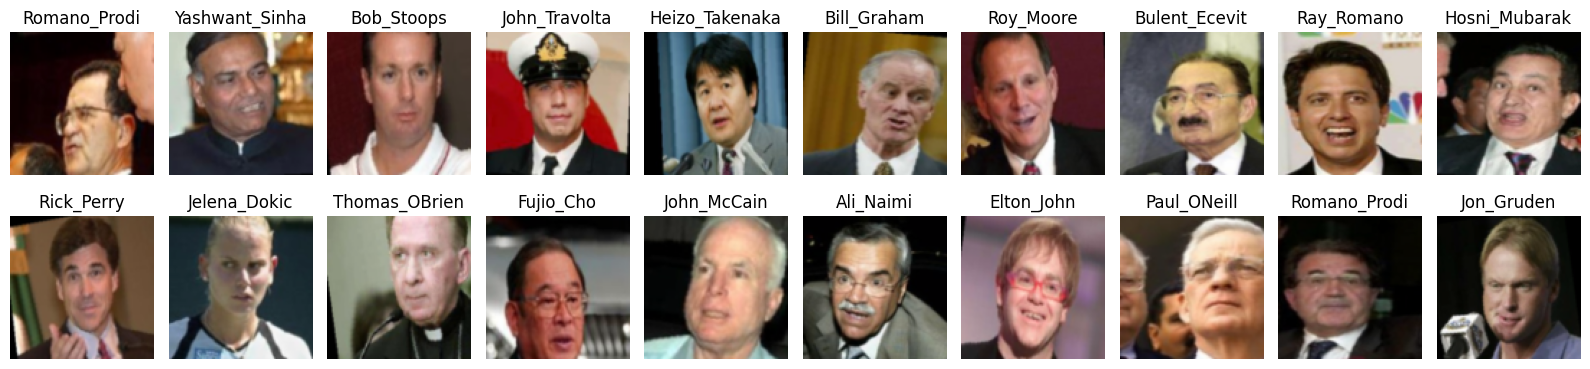

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

g

def denormalize(imgtensor):
    img = imgtensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.4299, 0.3747, 0.3324])
    std = np.array([0.2971, 0.2721, 0.2654])
    img = std * img + mean
    return np.clip(img, 0, 1)

fig, axes = plt.subplots(2, 10, figsize=(16, 4))
for ax in axes.flat:
    idx = np.random.randint(0, len(train_ds))
    img, label = train_ds[idx]
    ax.imshow(denormalize(img))
    ax.set_title(train_ds.classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

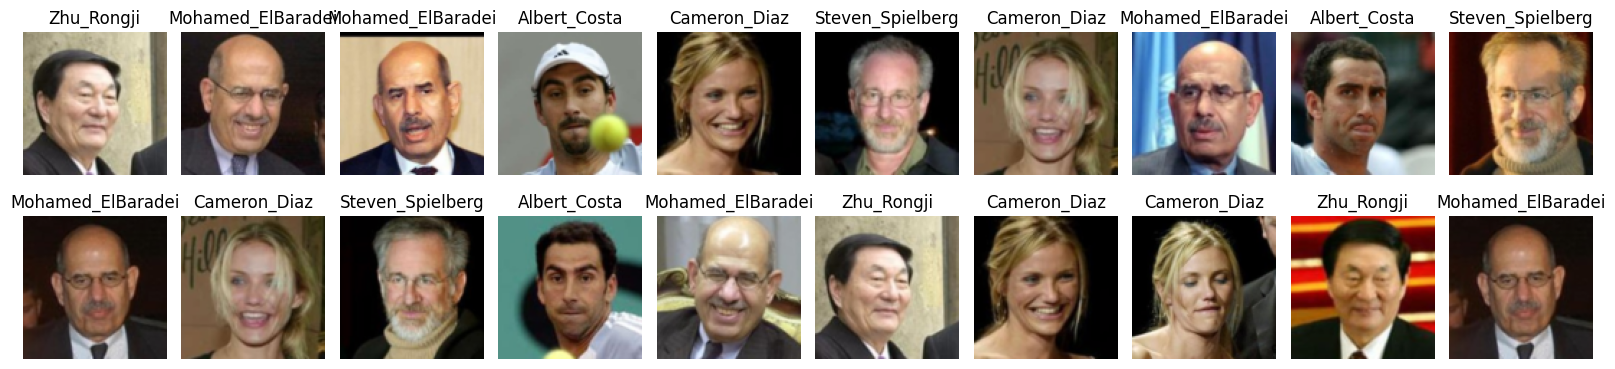

In [ ]:
g

fig, axes = plt.subplots(2, 10, figsize=(16, 4))
for ax in axes.flat:
    idx = np.random.randint(0, len(test_ds))
    img, label = test_ds[idx]
    ax.imshow(denormalize(img))
    ax.set_title(test_ds.classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

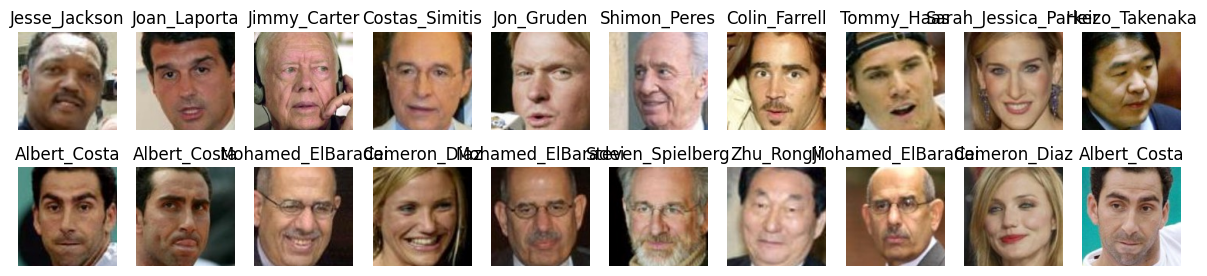

In [ ]:
### YOUR CODE HERE ###

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

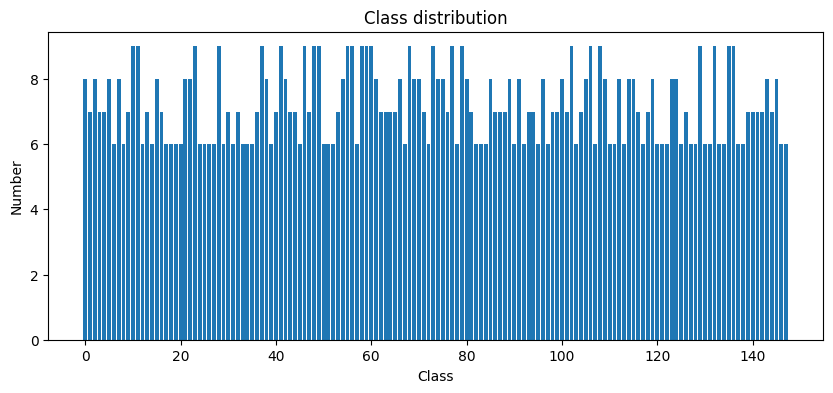

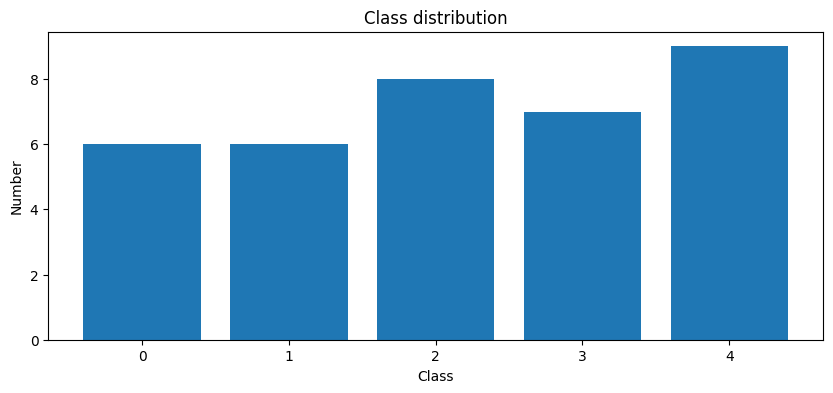

In [ ]:
from collections import Counter

def show_class_distribtion(targets):
    ### YOUR CODE HERE ###

    counter = Counter(np.array(targets))
    counts = [counter[i] for i in sorted(counter.keys())]

    plt.figure(figsize=(10, 4))
    plt.bar(sorted(counter.keys()), counts)

    plt.xlabel('Class')
    plt.ylabel('Number')
    plt.title('Class distribution')
    plt.show()

show_class_distribtion(train_ds.targets)
show_class_distribtion(test_ds.targets)

##### [0 баллов] Задание 1.2. Датасет пар.

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \
К счастью, весь датасет уже написан.

In [ ]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in tqdm.trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)

    def _idx2(self, idx):
        return idx // len(self.dataset)

    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)

train_pairs = PairDataset(train_ds)
test_pairs = PairDataset(test_ds)

100%|██████████| 1296/1296 [00:00<00:00, 1449551.46it/s]


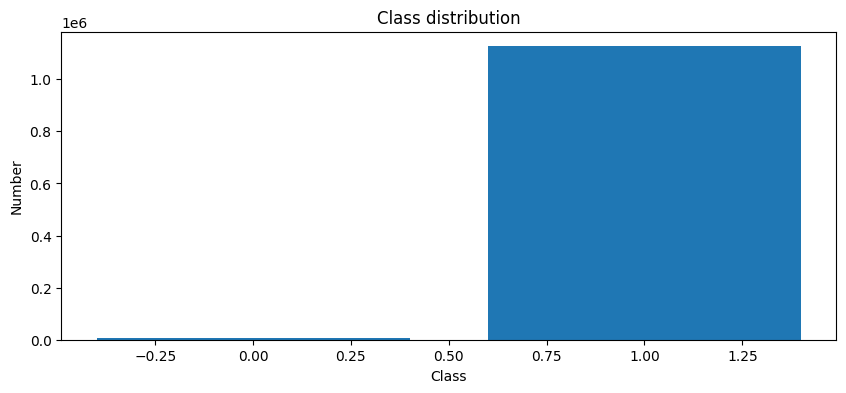

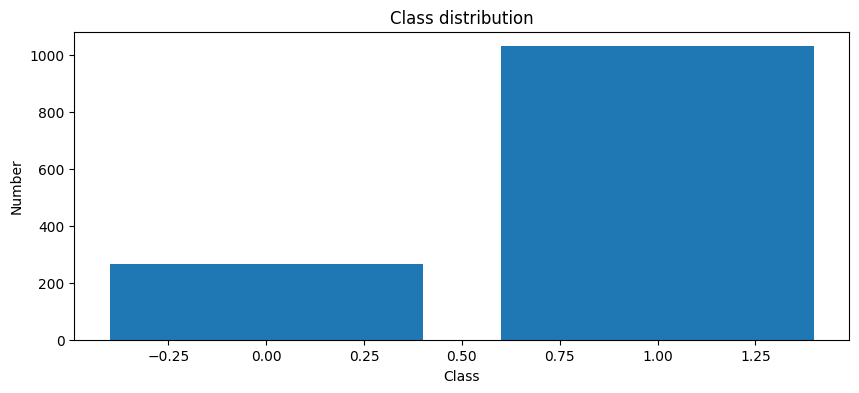

In [ ]:
show_class_distribtion(train_pairs.targets)
show_class_distribtion(test_pairs.targets)

Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

##### [1 балл] Задание 1.3. Стратифицированный даталоадер.

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".

Как известно, стандартный класс `DataLoader` в torch имеет много параметров. В частности, параметр `sampler` позволяет гибко управлять выдачей. Изучите [документацию](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) и реализуйте свой семплер, который решит проблему.

В `pytorch_metric_learning` уже есть готовая реализация того, что нам нужно. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.4__.

In [ ]:
class BalancedSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        targets = np.array(dataset.targets)

        self.c0_indices = np.where(targets == 0)[0]
        self.c1_indices = np.where(targets == 1)[0]

        self.samp_class = batch_size // 2
        self.num_batches = min(len(self.c0_indices), len(self.c1_indices)) // self.samp_class

    def __iter__(self):
        np.random.shuffle(self.c0_indices)
        np.random.shuffle(self.c1_indices)

        for i in range(self.num_batches):
            batch_c0 = self.c0_indices[i * self.samp_class : (i + 1) * self.samp_class]
            batch_c1 = self.c1_indices[i * self.samp_class : (i + 1) * self.samp_class]

            batch_indices = np.hstack([batch_c0, batch_c1])
            np.random.shuffle(batch_indices)
            yield batch_indices.tolist()

    def __len__(self):
        return self.num_batches

In [ ]:
### YOUR CODE HERE ###

g
train_pairs_sampler = BalancedSampler(train_pairs, batch_size=32)

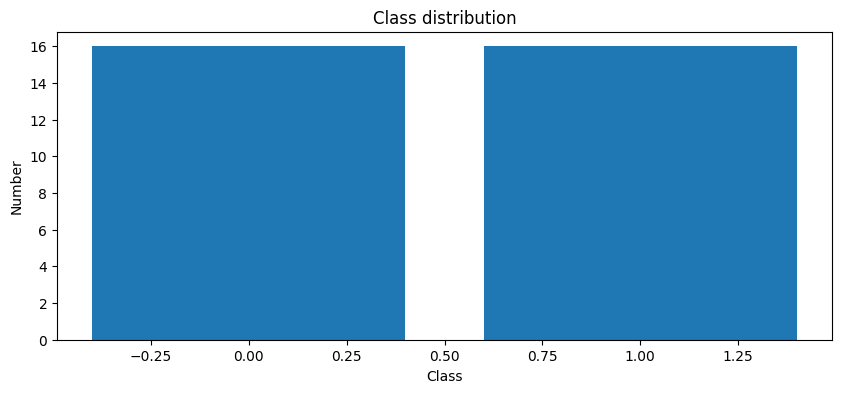

In [ ]:
g

train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_sampler = train_pairs_sampler)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size = 64, shuffle = False)

# Убедимся, что теперь выдача равномерная.

show_class_distribtion(next(iter(train_pairs_loader))[2])

### [3.5 балла] Часть 2. Классификация.

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуйте и обучите обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### [1 балл] Задание 2.1. Модель классификации.

Сначала нужно реализовать модель. В `forward` необходимо принять два батча фотографий. `i`-e число в выводе `forward` должно быть предсказанием для пары из `i`-й фотографии `image1` и `i`-й фотографии `image2`. Подумайте, как это сделать. Возможно, стоит как-нибудь склеить `image1` и `image2`? Или склеить эмбеддинги? А может быть нужен какой-то трешхолд?

Вы вольны использовать любую архитектуру сети. Ассерт в конце ячейки поможет вам убедиться, что модель теоретически делает то, что нужно.

In [ ]:
from torch import nn

In [ ]:
class ClassificationNet(torch.nn.Module):
    def __init__(self):
        ### YOUR CODE HERE ###
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4,
                      kernel_size=3, padding='same'),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=4, out_channels=16,
                      kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

        )

        self.classifier = torch.nn.Sequential(
            nn.Linear(128 * 3 * 3, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )


    def forward(self, image1, image2):
        ### YOUR CODE HERE ###
        emb1 = self.encoder(image1).flatten(1)
        emb2 = self.encoder(image2).flatten(1)

        combo = torch.abs(emb1 - emb2)
        res = self.classifier(combo)

        return res.squeeze(1)

# Вы можете использовать этот ассерт в качестве теста, что ваша модель делает то, что нужно.
assert ClassificationNet()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

##### [2 балла] Задание 2.2. Обучение.

Теперь обучите свою модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 2.5 \cdot \dfrac{AucRoc - 0.6}{0.2}, 2.5) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.8`

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1)

In [ ]:
from tqdm.auto import tqdm
import wandb

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc, wandb_project=None):
    train_loss = 0.0
    train_labels = []
    train_preds = []

    model.train()
    for im1, im2, labels in tqdm(train_loader, desc=tqdm_desc):
        im1 = im1.to(device)
        im2 = im2.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        logits = model(im1, im2)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)

        if wandb_project:
            wandb.log({'batch-train/loss': loss.item()})

        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(logits.detach().cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_roc_auc = sklearn.metrics.roc_auc_score(train_labels, train_preds)

    return train_loss, train_roc_auc

@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc):

    val_loss = 0.0
    val_labels = []
    val_preds = []

    model.eval()
    for im1, im2, labels in tqdm(val_loader, desc=tqdm_desc):
        im1 = im1.to(device)
        im2 = im2.to(device)
        labels = labels.float().to(device)

        logits = model(im1, im2)
        loss = criterion(logits, labels)

        val_loss += loss.item() * labels.shape[0]

        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(logits.detach().cpu().numpy())


    val_loss /= len(val_loader.dataset)

    val_roc_auc = sklearn.metrics.roc_auc_score(val_labels, val_preds)

    return val_loss, val_roc_auc


def train(
    model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler=None,
    wandb_project=None, config=None):

    train_losses = []
    val_losses = []
    roc_aucs = []

    if wandb_project:
        wandb.init(
            project=wandb_project,
            config=config
        )
        wandb.watch(model)

    for epoch in range(1, num_epochs + 1):
        train_loss, train_roc_auc = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}',
            wandb_project=wandb_project
        )
        val_loss, val_roc_auc = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        roc_aucs.append(val_roc_auc)

        print(f'Epoch: {epoch}, Val Loss: {val_loss}, Val ROC AUC: {val_roc_auc}')

        if scheduler is not None:
            scheduler.step()

        if wandb_project:
            metrics = {
                'train_loss': train_loss,
                'train_roc_auc': train_roc_auc,
                'val_loss': val_loss,
                'val_roc_auc': val_roc_auc
            }
            wandb.log(metrics)

In [ ]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chipdeol (chipdeol-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch.optim as optim

In [ ]:
### YOUR CODE HERE ###
g

model = ClassificationNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCELoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_pairs_loader,
    val_loader=test_pairs_loader,
    num_epochs=10,
    scheduler=scheduler,
    wandb_project='faces_classification',
    config={
        'lr': 1e-4,
        'epochs': 10,
        'batch_size': 32,
        'model': 'ClassificationNet'
    })

batch-train/loss,█▆▆▆▆▄▇▆▆▆▆▆▅▆▃▅▄▄▃▅▃▄▅▅▄▃█▃▇▅▄▆▆▄█▁▂▃▄▄
train_loss,█▆▄▃▂▁
train_roc_auc,▁▄▅▆▇█
val_loss,█▇▄▄▂▁
val_roc_auc,▁▄▅▆██
batch-train/loss,0.46565
train_loss,0.00748
train_roc_auc,0.79549
val_loss,0.4083
val_roc_auc,0.92252


Training 1/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 1/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1, Val Loss: 0.5904032271585347, Val ROC AUC: 0.7864661654135339


Training 2/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 2/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 2, Val Loss: 0.4713332211529767, Val ROC AUC: 0.8508212278268488


Training 3/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 3/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 3, Val Loss: 0.4657236161055388, Val ROC AUC: 0.8721804511278195


Training 4/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 4/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 4, Val Loss: 0.4735189411375258, Val ROC AUC: 0.8902547631213957


Training 5/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 5/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 5, Val Loss: 0.46456245286965075, Val ROC AUC: 0.9010584714212717


Training 6/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 6/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 6, Val Loss: 0.45927888964429314, Val ROC AUC: 0.8980655522300899


Training 7/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 7/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 7, Val Loss: 0.4297076640305696, Val ROC AUC: 0.9143441127089568


Training 8/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 8/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 8, Val Loss: 0.40616551519911964, Val ROC AUC: 0.9274399591211038


Training 9/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 9/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 9, Val Loss: 0.3776350963262864, Val ROC AUC: 0.9207679392656398


Training 10/10:   0%|          | 0/490 [00:00<?, ?it/s]

Validating 10/10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10, Val Loss: 0.38476750328217024, Val ROC AUC: 0.92644718592598


In [ ]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm(test_pairs_loader):
        with torch.no_grad():
            output = your_model(images1.to(device), images2.to(device))
        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

get_score(get_auc_roc(model))

  0%|          | 0/21 [00:00<?, ?it/s]

2.5

УРАААА

##### [0.5 балла] Задание 2.3. Анализ и отчет.

Опишите свои эксперименты. Проанализируйте результаты. Почему результаты получились не очень хорошими? Может быть, решать задачу через бинарную классификацию - не лучшая идея? Приведите не менее 3 аргументов, почему это так.

Это задание меня убило, я делала его три дня(((

**Эксперименты:**

Сначала все было очень плохо (AUC ROC был около 0.49), но я выяснила, что проблема была в моем сэмплере, я ошиблась, когда писала функцию.

С исправленным сэмплером стало чуть лучше, но качество было маленькое (AUC ROC был около 0.55, и модель почти не обучалась, так как train loss почти не менялся). Что я сделала:

1) увеличила количество эпох с 5 до 10: стало лучше! AUC ROC = 0.68
2) дальше я пыталась менять learning rate, делала архитектуру модели глубже, но качество почти не менялась
3) и тут я решила поменять forward самой модели: раньше у меня было объединение эмбеддингов, но я поменяла на модуль разности (объясняя тем, что чем больше модуль разности, тем более НЕ похожи фотографии, следовательно, на фото разные люди) и это СИЛЬНО улучшило модель (как видно, качество очень возросло, теперь AUC ROC = 0.93)

**Результаты:**

Результаты получились не очень плохими (AUC ROC высокий), но отличными мы их назвать все равно не можем, так как:

1) есть переобучение (train loss на протяжении всего обучения был очень маленьким)
2) n изображений в выборке дают нам n^2 пар в датасете, большинство пар — разные люди, следовательно, преобладает 1 класс, что приводит к дисбалансу классов
3) бинарная классификация предсказывает один человек на двух фото или нет, но она не говорит, как сильно люди с двух изображений похожи друг на друга

4) я делала это задание 3 дня, мне плохо...

### [5 баллов] Часть 3. Распознавание лиц.

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### [2 балла] Задание 3.1. Триплетная функция потерь.

Напомним теорию. Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$

В этом задании вам необходимо реализовать этот функционал. Для удобства в дальнейшем, предлагается сразу реализовать batch-версию. Таким образом, на входе должно быть 2 параметра:
- Набор эмбеддингов размера (batch_size, embedding_size)
- Набор классов (номера людей, чьи это фотографии) размера (batch_size)

Ваша функция должна найти все тройки $(A, P, N)$ и вычислить лосс для них.

В `pytorch_metric_learning` уже есть готовая реализация. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.5__.

In [ ]:
#вдохновилась здесь https://www.codegenes.net/blog/batch-hard-triplet-loss-pytorch/
import torch.nn.functional as F

def BatchTriplet(embeddings, labels, margin = 0.25):

    batch_size = embeddings.size(0)
    pair_dist = torch.cdist(embeddings, embeddings, p = 2)

    losses = 0
    c = 0

    for i in range(batch_size):
        pos_mask = labels == labels[i]
        pos_mask[i] = False #не считаем сам объект
        neg_mask = labels != labels[i]

        pos_dist = pair_dist[i][pos_mask]
        neg_dist = pair_dist[i][neg_mask]

        for p in pos_dist:
            for n in neg_dist:
                loss = F.relu(p - n + margin)
                losses += loss
                c += 1

    return losses / c

In [ ]:
criterion = BatchTriplet
### YOUR CODE HERE ###(margin = 0.25)

In [ ]:
# Вы можете использовать этот ассерт в качестве теста
embeddings = torch.tensor([
    [ 1., 2, 3 ],
    [ 1, 3, 4 ],
    [ 4, 5, 6 ]
])
labels = torch.tensor([ 1., 2, 1 ])
assert (criterion(embeddings, labels) - 2.6775) < 1e-4

##### [3 балла] Задание 3.2. Обучение.

Теперь обучите модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 3 \cdot \dfrac{AucRoc - 0.8}{0.15}, 3) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.95`

При необходимости, вы можете улучшить функцию потерь. Например, учитывать не все тройки, а только "сложные", как это умеет делать реализация в `pytorch_metric_learning`. Также подумайте над даталоадером. Возможно, имеет смысл брать в батч одинаковое количество фотографий каждого человека по аналогии с заданием 1.3? Тем не менее имейте в виду, что для получения полного балла за задание, вы должны реализовать все модификации самостоятельно, а не использовать готовые.

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1.5) \
__При использовани pytorch_metric_learning, балл за это задание уменьшается на 0.5 за каждое использование__

In [ ]:
### YOUR CODE HERE ###

class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.final = nn.Sequential(
            nn.Flatten(),

            nn.Linear(128 * 12 * 12, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.final(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [ ]:
class BalancedTripletSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, n_persons=8, n_samp=4):
        self.dataset = dataset
        self.n_persons = n_persons
        self.n_samp = n_samp

        self.label_to_indices = {}
        for idx, label in enumerate(dataset.targets):
            self.label_to_indices.setdefault(label, []).append(idx)

        self.labels = list(self.label_to_indices.keys())
        self.num_batches = len(self.labels) // self.n_persons

    def __iter__(self):
        np.random.shuffle(self.labels)
        for i in range(self.num_batches):
            labels1 = self.labels[i * self.n_persons:(i + 1) * self.n_persons]
            batch_indices = []
            for label in labels1:
                idxs = np.random.choice(self.label_to_indices[label], self.n_samp, replace=True)
                batch_indices.extend(idxs)
            yield batch_indices

    def __len__(self):
        return self.num_batches

In [ ]:
g
train_triplet_sampler = BalancedTripletSampler(train_ds)

train_loader = torch.utils.data.DataLoader(train_ds, batch_sampler=train_triplet_sampler)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [ ]:
from tqdm.auto import tqdm

def training_epoch(model, optimizer, train_loader, tqdm_desc, wandb_project=None):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        loss = BatchTriplet(embeddings, labels, margin=0.25)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)

        if wandb_project:
            wandb.log({'batch-train/loss': loss.item()})

    return train_loss / len(train_loader.dataset)


@torch.no_grad()
def validation_epoch(model, val_loader, tqdm_desc):
    model.eval()
    val_loss = 0.0
    val_embeddings = []
    val_labels = []

    for images, labels in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)
        embeddings = model(images)
        loss = BatchTriplet(embeddings, labels, margin=0.25)
        val_loss += loss.item() * labels.size(0)

        val_embeddings.append(embeddings.cpu())
        val_labels.append(labels.cpu())

    val_embeddings = torch.cat(val_embeddings, dim=0)
    val_labels = torch.cat(val_labels, dim=0)

    preds, targets = [], []
    for i in range(val_embeddings.size(0)):
        for j in range(i + 1, val_embeddings.size(0)):
            dist = torch.norm(val_embeddings[i] - val_embeddings[j]).item()
            preds.append(-dist)
            targets.append(int(val_labels[i] == val_labels[j]))

    auc_roc = sklearn.metrics.roc_auc_score(targets, preds)
    val_loss = val_loss / len(val_loader.dataset)

    return val_loss, auc_roc


def train(
    model, optimizer, train_loader, val_loader, num_epochs,
    margin=0.25, scheduler=None, wandb_project=None, config=None):

    train_losses = []
    val_losses = []
    roc_aucs = []

    if wandb_project:
        wandb.init(
            project=wandb_project,
            config=config
        )
        wandb.watch(model)

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}',
            wandb_project=wandb_project
        )

        val_loss, roc_auc = validation_epoch(
            model, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        roc_aucs.append(roc_auc)

        print(f'Epoch: {epoch}, Val Loss: {train_loss}, Val ROC AUC: {roc_auc}')

        if scheduler is not None:
            scheduler.step()

        if wandb_project:
            metrics = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_roc_auc': roc_auc
            }
            wandb.log(metrics)

In [ ]:
import torch.optim as optim

In [ ]:
### YOUR CODE HERE ###
g

model = EmbeddingNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=15,
    scheduler=scheduler,
    wandb_project='faces_triplet',
    config={
        'lr': 1e-3,
        'epochs': 15,
        'batch_size': 32,
        'model': 'ClassificationNet'
    })

Training 1/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 1/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Val Loss: 0.10357284501124996, Val ROC AUC: 0.6708991135500211


Training 2/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 2/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Val Loss: 0.09763436115963359, Val ROC AUC: 0.7246264246517519


Training 3/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 3/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Val Loss: 0.0936755444522195, Val ROC AUC: 0.7390797804981004


Training 4/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 4/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Val Loss: 0.08955811446821185, Val ROC AUC: 0.7537864077669904


Training 5/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 5/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Val Loss: 0.08823774118378688, Val ROC AUC: 0.813440270156184


Training 6/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 6/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Val Loss: 0.079056556907618, Val ROC AUC: 0.8570367243562685


Training 7/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 7/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Val Loss: 0.07434785847372852, Val ROC AUC: 0.8602448290417897


Training 8/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 8/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Val Loss: 0.06813262639471063, Val ROC AUC: 0.8817391304347826


Training 9/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 9/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Val Loss: 0.06481407438645341, Val ROC AUC: 0.8701899535669058


Training 10/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 10/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Val Loss: 0.06934748971965951, Val ROC AUC: 0.9170113972140144


Training 11/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 11/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Val Loss: 0.0681613241562821, Val ROC AUC: 0.9317686787674124


Training 12/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 12/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Val Loss: 0.06630124956229483, Val ROC AUC: 0.9341156606162938


Training 13/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 13/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Val Loss: 0.062079090467641054, Val ROC AUC: 0.9358041367665683


Training 14/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 14/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Val Loss: 0.06391407111441026, Val ROC AUC: 0.9375770367243562


Training 15/15:   0%|          | 0/18 [00:00<?, ?it/s]

Validating 15/15:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Val Loss: 0.06039103409494033, Val ROC AUC: 0.9547150696496411


In [ ]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm(test_pairs_loader):
        with torch.no_grad():
            emb1 = your_model(images1.to(device))
            emb2 = your_model(images2.to(device))
            # Вы можете изменить функцию расстояния между эмбеддингами, если считаете нужным
            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

get_score(get_auc_roc(model))

  0%|          | 0/21 [00:00<?, ?it/s]

3

Ура-ура!!

Сначала я уменьшила learning rate, но качество стало хуже (ROC AUC уменьшилась), потом я увеличила количество эпох с 5 до 10, стало лучше (ROC AUC увеличился с 0,86 до 0,89). Дальше я увеличила выходного слоя нейронной сети, то есть размер эмбеддинга, что сделало модель намного лучше и я добилась желаемого качества. Видим, что чем больше размерность эмбеддинга, тем больше информации о фото мы получаем, что и улучшает нашу модель.

##### [0.1 балла] Бонус: распознай себя

В качестве бонуса, загрузите свою фотографию (можно не одну), пропустите ее через модель и определите, на кого из известных людей, по мнению модели, вы больше всего похоже.

In [ ]:
### YOUR CODE HERE ###
celebrity_embeddings = []
celebrity_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Celebrity embedding :)'):
        images = images.to(device)
        emb = model(images)
        celebrity_embeddings.append(emb.cpu())
        celebrity_labels.extend(labels.cpu().numpy())

celebrity_embeddings = torch.cat(celebrity_embeddings)
celebrity_labels = np.array(celebrity_labels)

Celebrity embedding :):   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4299, 0.3747, 0.3324],
                         std=[0.2971, 0.2721, 0.2654])
])

image = Image.open('my_photo.jpeg').convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)

In [ ]:
with torch.no_grad():
    my_embedding = model(image_tensor).cpu()

In [ ]:
dists = torch.norm(celebrity_embeddings - my_embedding, dim=1)
closest_idx = torch.argmin(dists).item()
closest_label = celebrity_labels[closest_idx]

я больше всего похожа на Steven_Spielberg


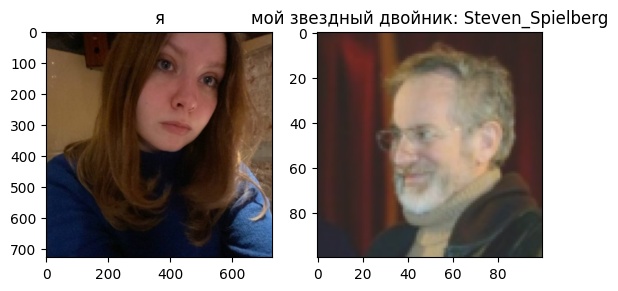

In [ ]:
print(f'я больше всего похожа на {test_ds.classes[closest_label]}')

import matplotlib.pyplot as plt

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

plt.subplot(1, 2, 1)
plt.imshow(Image.open('my_photo.jpeg'))
plt.title('я')

plt.subplot(1, 2, 2)
plt.imshow(denormalize(test_ds[closest_idx][0]).permute(1, 2, 0).clip(0, 1))
plt.title(f'мой звездный двойник: {test_ds.classes[closest_label]}')
plt.show()